In [13]:
import sys, datetime
sys.path.append("../../scripts/")
from s3_support import *

import pandas as pd
import numpy as np
%matplotlib inline

# data prep

In [14]:
template_upgrades = pd.read_csv("converted_forms_dates.csv")
daily_conversions = pd.read_csv("forms_conversion.csv")
device_conversions = pd.read_csv("forms_device_conversion.csv")

template_upgrades['created'] = pd.to_datetime(template_upgrades['created'])
daily_conversions['date'] = pd.to_datetime(daily_conversions['date'])
daily_conversions['avg_onetime'] = daily_conversions['volume_onetime'] / daily_conversions['count_onetime']
daily_conversions['avg_recurring'] = daily_conversions['volume_recurring'] / daily_conversions['count_recurring']
daily_conversions['onetime / recurring'] = daily_conversions['count_onetime'] / daily_conversions['count_recurring']

device_conversions['date'] = pd.to_datetime(device_conversions['date'])
device_conversions['avg_onetime'] = device_conversions['volume_onetime'] / device_conversions['count_onetime']
device_conversions['avg_recurring'] = device_conversions['volume_recurring'] / device_conversions['count_recurring']
device_conversions['onetime / recurring'] = device_conversions['count_onetime'] / device_conversions['count_recurring']

In [15]:
# isolate list of form IDs that have been converted
converted_forms = template_upgrades['form'].unique().tolist()

In [16]:
# get active forms percentage of converted forms
q = "select id, status from form"
forms = redshift_query_read(q, schema="production")
forms_statuses_conv = forms[forms['id'].isin(converted_forms)]
active_converted_forms_count = forms_statuses_conv['status'].value_counts()[1]
active_converted_forms_perc = forms_statuses_conv['status'].value_counts(normalize=True)[1]

In [17]:
# recurring frequencies
rec_frequencies = pd.read_csv("recurring_frequencies.csv")
rec_frequencies['created'] = pd.to_datetime(rec_frequencies['created'])
rec_frequencies['frequency'] = pd.to_timedelta(rec_frequencies['frequency'])

In [18]:
daily_conversions = daily_conversions[daily_conversions['pageviews']>0]
daily_conversions['conversion_onetime'] = daily_conversions['count_onetime'] / daily_conversions['pageviews']
daily_conversions['conversion_recurring'] = daily_conversions['count_recurring'] / daily_conversions['pageviews']

In [19]:
# device conversions
device_conversions = pd.read_csv("device_conversions.csv")
device_conversions['date'] = pd.to_datetime(device_conversions['date'])

def get_template_type(r):
    if r['form'] in template_upgrades['form'].tolist():
        if r['date']>=template_upgrades[template_upgrades['form']==r['form']]['created'].iloc[0]:
            return True
    return False

device_conversions['new template'] = device_conversions.apply(get_template_type, axis=1)

# analysis

In [20]:
converted_daily_entries = daily_conversions[daily_conversions['form'].isin(template_upgrades['form'].unique().tolist())]
converted_trans_sum = converted_daily_entries['count_onetime'].sum() + converted_daily_entries['count_recurring'].sum()
converted_trans_perc = (converted_trans_sum / (daily_conversions['count_onetime'].sum() + daily_conversions['count_recurring'].sum())) * 100.

print("converted forms: {:,}".format(len(converted_forms)))
print("converted forms w/ active status: {:.2f}%".format(active_converted_forms_perc * 100.))
print("converted forms w/ transactions: {:,}".format(len(converted_daily_entries['form'].unique())))
print("total transactions of converted forms: {:,} ({:.2f}%)".format(converted_trans_sum, converted_trans_perc))

converted forms: 2,298
converted forms w/ active status: 68.24%
converted forms w/ transactions: 421
total transactions of converted forms: 161,926.0 (11.51%)


In [21]:
device_conversions.columns

Index(['date', 'form', 'desktop_pageviews', 'mobile_pageviews',
       'onetime_desktop', 'onetime_mobile', 'recurring_desktop',
       'recurring_mobile', 'onetime_desktop_conversion',
       'onetime_mobile_conversion', 'recurring_desktop_conversion',
       'recurring_mobile_conversion', 'new template'],
      dtype='object')

In [22]:
min_year = daily_conversions['date'].min().year

# one time
conv_mean = daily_conversions['conversion_onetime'].mean()
conv_median = daily_conversions['conversion_onetime'].median()

print("All forms ({}+) - one time:".format(min_year))
print("-"*40)
print("Conversion:")
print("\tMean: {:.2f}%".format(conv_mean * 100.))
print("\tMedian: {:.2f}%".format(conv_median * 100.))
print("Per transaction:")
print("\tMean: ${:,.2f}".format(daily_conversions['avg_onetime'].mean()))
print("\tMedian: ${:,.2f}".format(daily_conversions['avg_onetime'].median()))

print()
onetime_cols = ['onetime_desktop_conversion', 'onetime_mobile_conversion']
print(device_conversions[onetime_cols].replace([np.inf, -np.inf], np.nan).dropna().mean())

# recurring
conv_mean = daily_conversions['conversion_recurring'].mean()
conv_median = daily_conversions['conversion_recurring'].median()

print()
print("All forms ({}+) - recurring:".format(min_year))
print("-"*40)
print("Conversion:")
print("\tMean: {:.2f}%".format(conv_mean * 100.))
print("\tMedian: {:.2f}%".format(conv_median * 100.))
print("Per transaction:")
print("\tMean: ${:,.2f}".format(daily_conversions['avg_recurring'].mean()))
print("\tMedian: ${:,.2f}".format(daily_conversions['avg_recurring'].median()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(rec_frequencies['frequency'].mean()))
print("\tMedian: {}".format(rec_frequencies['frequency'].median()))

print()
print("One time / Recurring: {:.2f}".format(daily_conversions['onetime / recurring'].mean()))

All forms (2016+) - one time:
----------------------------------------
Conversion:
	Mean: 1.68%
	Median: 0.00%
Per transaction:
	Mean: $244.01
	Median: $100.08

onetime_desktop_conversion    0.092326
onetime_mobile_conversion     0.047873
dtype: float64

All forms (2016+) - recurring:
----------------------------------------
Conversion:
	Mean: 1.81%
	Median: 0.00%
Per transaction:
	Mean: $1,061.89
	Median: $45.00

Recurring frequency:
	Mean: 25 days 15:30:19.035327175
	Median: 26 days 03:25:42.857142857

One time / Recurring: 2.11


In [23]:
def was_converted(r):
    if r['form'] in template_upgrades['form'].tolist():
        if r['date'] >= template_upgrades[template_upgrades['form']==r['form']]['created'].iloc[0]:
            return True
    
    return False

daily_conversions['new template'] = daily_conversions.apply(was_converted, axis=1)
device_conversions['new template'] = device_conversions.apply(was_converted, axis=1)

In [24]:
daily_conversions['new template'].value_counts()

False    3389032
True        9232
Name: new template, dtype: int64

In [25]:
daily_conversions[daily_conversions['new template']]['date'].min()

Timestamp('2020-12-11 00:00:00')

In [26]:
min_date = '2020-09-01'

print("Isolated time frame to approximately when processing begins with new forms ({}+), all forms:".format(min_date))
print()

date_iso = daily_conversions[daily_conversions['date']>=min_date]
len_all_forms = len(date_iso['form'].unique())
len_all_trans = date_iso['count_onetime'].sum() + date_iso['count_recurring'].sum()
device_date_iso = device_conversions[device_conversions['date']>=min_date]

nuform_device = device_date_iso[device_date_iso['new template']]
nuform_rec_frequency = rec_frequencies[(rec_frequencies['new template'])&(rec_frequencies['created']>=min_date)]

nuform = date_iso[date_iso['new template']]
len_nuform_forms = len(nuform['form'].unique())
len_nuform_trans = nuform['count_onetime'].sum() + nuform['count_recurring'].sum()

print("New form:")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_nuform_forms, (len_nuform_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_nuform_trans, (len_nuform_trans / len_all_trans) * 100.))

print("conversion:")
print("\tOne time mean: {:.2f}%".format(nuform['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(nuform['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(nuform['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(nuform['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(nuform['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(nuform['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(nuform['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(nuform['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(nuform['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(nuform_rec_frequency['frequency'].mean()))
print("\tMedian: {}".format(nuform_rec_frequency['frequency'].median()))

print()
print("Settings")
print("Appearance:")
print("\tMean: {}".format(nuform['appearance'].mean()))
print("\tMedian: {}".format(nuform['appearance'].median()))
print("Recurring CTA before:")
print("\tMean: {}".format(nuform['recurring_cta_before'].mean()))
print("\tMedian: {}".format(nuform['recurring_cta_before'].median()))
print("Recurring CTA after:")
print("\tMean: {}".format(nuform['recurring_cta_after'].mean()))
print("\tMedian: {}".format(nuform['recurring_cta_after'].median()))
print("Conditional fields:")
print("\tMean: {}".format(nuform['conditional_fields'].mean()))
print("\tMedian: {}".format(nuform['conditional_fields'].median()))

print()

oldform_rec_frequency = rec_frequencies[(~rec_frequencies['new template'])&(rec_frequencies['created']>=min_date)]
oldform_device = device_date_iso[~device_date_iso['new template']]
oldform = date_iso[~date_iso['new template']]
len_oldform_forms = len(oldform['form'].unique())
len_oldform_trans = oldform['count_onetime'].sum() + oldform['count_recurring'].sum()

print("Old form:")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_oldform_forms, (len_oldform_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_oldform_trans, (len_oldform_trans / len_all_trans) * 100.))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(oldform['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(oldform['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(oldform['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(oldform['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(oldform['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(oldform['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(oldform['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(oldform['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(oldform['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(oldform_rec_frequency['frequency'].mean()))
print("\tMedian: {}".format(oldform_rec_frequency['frequency'].median()))

Isolated time frame to approximately when processing begins with new forms (2020-09-01+), all forms:

New form:
----------------------------------------
Form sample size: 363 (4.77%)
Transaction sample size: 8,148.0 (2.48%)
conversion:
	One time mean: 5.14%
	One time median: 0.00%
	Recurring mean: 8.23%
	Recurring median: 0.00%
per transaction:
	One time mean: $297.80
	One time median: $104.31
	Recurring mean: $64.08
	Recurring median: $41.56

One time / recurring: 1.64

Recurring frequency:
	Mean: 9 days 09:22:54.097135740
	Median: 11 days 10:24:00

Settings
Appearance:
	Mean: 0.14406412478336222
	Median: 0.0
Recurring CTA before:
	Mean: 0.060008665511265165
	Median: 0.0
Recurring CTA after:
	Mean: 0.0030329289428076256
	Median: 0.0
Conditional fields:
	Mean: 0.0009748700173310225
	Median: 0.0

Old form:
----------------------------------------
Form sample size: 7,606 (99.92%)
Transaction sample size: 320,008.0 (97.52%)
conversion:
	One time mean: 2.76%
	One time median: 0.00%
	Recurr

In [27]:
overall_conv = nuform[['form', 'date', 'count_recurring', 'count_onetime', 'pageviews']].copy()
overall_conv['conversion'] = (overall_conv['count_recurring'] + overall_conv['count_onetime']) / overall_conv['pageviews']
print("New form conversion: {:.2f}%".format(overall_conv['conversion'].mean() * 100.))

oldform
overall_conv = oldform[['form', 'date', 'count_recurring', 'count_onetime', 'pageviews']].copy()
overall_conv['conversion'] = (overall_conv['count_recurring'] + overall_conv['count_onetime']) / overall_conv['pageviews']
print("Old form conversion: {:.2f}%".format(overall_conv['conversion'].mean() * 100.))

New form conversion: 13.37%
Old form conversion: 5.78%


In [28]:
print("Forms w/ transactions in new & old, isolated timeframe:")
print()

nuoldform_device = nuform_device[nuform_device['form'].isin(oldform_device['form'].unique().tolist())]
nuoldform_rec_frequency = nuform_rec_frequency[nuform_rec_frequency['form'].isin(oldform_rec_frequency['form'].unique().tolist())]

nuoldform = nuform[nuform['form'].isin(oldform['form'].unique().tolist())]
len_nuoldform_forms = len(nuoldform['form'].unique())
len_nuoldform_trans = nuoldform['count_onetime'].sum() + nuoldform['count_recurring'].sum()

print("Converted form (after conversion):")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_nuoldform_forms, (len_nuoldform_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_nuoldform_trans, (len_nuoldform_trans / len_all_trans) * 100.))
print("Transactions per form: {:.2f}".format(nuoldform.groupby('form')['count_onetime'].sum().mean()))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(nuoldform['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(nuoldform['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(nuoldform['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(nuoldform['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(nuoldform['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(nuoldform['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(nuoldform['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(nuoldform['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(nuoldform['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(nuoldform_rec_frequency['frequency'].mean()))
print("\tMedian: {}".format(nuoldform_rec_frequency['frequency'].median()))

print()
print("Settings")
print("Appearance:")
print("\tMean: {}".format(nuoldform['appearance'].mean()))
print("\tMedian: {}".format(nuoldform['appearance'].median()))
print("Recurring CTA before:")
print("\tMean: {}".format(nuoldform['recurring_cta_before'].mean()))
print("\tMedian: {}".format(nuoldform['recurring_cta_before'].median()))
print("Recurring CTA after:")
print("\tMean: {}".format(nuoldform['recurring_cta_after'].mean()))
print("\tMedian: {}".format(nuoldform['recurring_cta_after'].median()))
print("Conditional fields:")
print("\tMean: {}".format(nuoldform['conditional_fields'].mean()))
print("\tMedian: {}".format(nuoldform['conditional_fields'].median()))

print()

oldconvform_device = oldform_device[oldform_device['form'].isin(nuform_device['form'].tolist())]
oldconvform_rec_frequency = oldform_rec_frequency[oldform_rec_frequency['form'].isin(nuform_rec_frequency['form'].unique().tolist())]

oldconvform = oldform[oldform['form'].isin(nuform['form'].tolist())]
len_oldconvform_forms = len(oldconvform['form'].unique())
len_oldconvform_trans = oldconvform['count_onetime'].sum() + oldconvform['count_recurring'].sum()

print("Converted Old form (prior to conversion):")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_oldconvform_forms, (len_oldconvform_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_oldconvform_trans, (len_oldconvform_trans / len_all_trans) * 100.))
print("Transactions per form: {:.2f}".format(oldconvform.groupby('form')['count_onetime'].sum().mean()))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(oldconvform['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(oldconvform['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(oldconvform['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(oldconvform['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(oldconvform['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(oldconvform['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(oldconvform['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(oldconvform['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(oldconvform['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(oldconvform_rec_frequency['frequency'].mean()))
print("\tMedian: {}".format(oldconvform_rec_frequency['frequency'].median()))

Forms w/ transactions in new & old, isolated timeframe:

Converted form (after conversion):
----------------------------------------
Form sample size: 357 (4.69%)
Transaction sample size: 8,148.0 (2.48%)
Transactions per form: 11.18
conversion:
	One time mean: 5.16%
	One time median: 0.00%
	Recurring mean: 8.26%
	Recurring median: 0.00%
per transaction:
	One time mean: $297.80
	One time median: $104.31
	Recurring mean: $64.08
	Recurring median: $41.56

One time / recurring: 1.64

Recurring frequency:
	Mean: 5 days 16:32:25.945945945
	Median: 0 days 00:00:00

Settings
Appearance:
	Mean: 0.14329202000434876
	Median: 0.0
Recurring CTA before:
	Mean: 0.05968688845401174
	Median: 0.0
Recurring CTA after:
	Mean: 0.0030441400304414
	Median: 0.0
Conditional fields:
	Mean: 0.0009784735812133072
	Median: 0.0

Converted Old form (prior to conversion):
----------------------------------------
Form sample size: 357 (4.69%)
Transaction sample size: 27,488.0 (8.38%)
Transactions per form: 40.21
conve

In [29]:
print("Forms w/ transactions in new & old, last 60 days:")
print()

sixty_days_ago = datetime.datetime.now() - pd.to_timedelta("60day")

nuoldform_device = nuform_device[(nuform_device['form'].isin(oldform_device['form'].unique().tolist()))&(nuform_device['date']>=sixty_days_ago)]
nuoldform_rec_frequency = nuform_rec_frequency[(nuform_rec_frequency['form'].isin(oldform_rec_frequency['form'].unique().tolist()))&(nuform_rec_frequency['created']>=sixty_days_ago)]

nuoldform = nuform[(nuform['form'].isin(oldform['form'].unique().tolist()))&(nuform['date']>=sixty_days_ago)]
len_nuoldform_forms = len(nuoldform['form'].unique())
len_nuoldform_trans = nuoldform['count_onetime'].sum() + nuoldform['count_recurring'].sum()

print("Converted form (after conversion):")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_nuoldform_forms, (len_nuoldform_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_nuoldform_trans, (len_nuoldform_trans / len_all_trans) * 100.))
print("Transactions per form: {:.2f}".format(nuoldform.groupby('form')['count_onetime'].sum().mean()))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(nuoldform['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(nuoldform['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(nuoldform['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(nuoldform['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(nuoldform['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(nuoldform['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(nuoldform['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(nuoldform['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(nuoldform['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(nuoldform_rec_frequency['frequency'].mean()))
print("\tMedian: {}".format(nuoldform_rec_frequency['frequency'].median()))

print()
print("Settings")
print("Appearance:")
print("\tMean: {}".format(nuoldform['appearance'].mean()))
print("\tMedian: {}".format(nuoldform['appearance'].median()))
print("Recurring CTA before:")
print("\tMean: {}".format(nuoldform['recurring_cta_before'].mean()))
print("\tMedian: {}".format(nuoldform['recurring_cta_before'].median()))
print("Recurring CTA after:")
print("\tMean: {}".format(nuoldform['recurring_cta_after'].mean()))
print("\tMedian: {}".format(nuoldform['recurring_cta_after'].median()))
print("Conditional fields:")
print("\tMean: {}".format(nuoldform['conditional_fields'].mean()))
print("\tMedian: {}".format(nuoldform['conditional_fields'].median()))

print()

oldconvform_device = oldform_device[(oldform_device['form'].isin(nuform_device['form'].tolist()))&(oldform_device['date']>=sixty_days_ago)]
oldconvform_rec_frequency = oldform_rec_frequency[(oldform_rec_frequency['form'].isin(nuform_rec_frequency['form'].tolist()))&(oldform_rec_frequency['created']>=sixty_days_ago)]

oldconvform = oldform[(oldform['form'].isin(nuform['form'].tolist()))&(oldform['date']>=sixty_days_ago)]
len_oldconvform_forms = len(oldconvform['form'].unique())
len_oldconvform_trans = oldconvform['count_onetime'].sum() + oldconvform['count_recurring'].sum()

print("Converted Old form (prior to conversion):")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_oldconvform_forms, (len_oldconvform_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_oldconvform_trans, (len_oldconvform_trans / len_all_trans) * 100.))
print("Transactions per form: {:.2f}".format(oldconvform.groupby('form')['count_onetime'].sum().mean()))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(oldconvform['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(oldconvform['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(oldconvform['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(oldconvform['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(oldconvform['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(oldconvform['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(oldconvform['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(oldconvform['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(oldconvform['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(oldconvform_rec_frequency['frequency'].mean()))
print("\tMedian: {}".format(oldconvform_rec_frequency['frequency'].median()))

Forms w/ transactions in new & old, last 60 days:

Converted form (after conversion):
----------------------------------------
Form sample size: 309 (4.06%)
Transaction sample size: 4,683.0 (1.43%)
Transactions per form: 6.95
conversion:
	One time mean: 6.10%
	One time median: 0.00%
	Recurring mean: 9.20%
	Recurring median: 0.00%
per transaction:
	One time mean: $301.03
	One time median: $104.09
	Recurring mean: $63.24
	Recurring median: $42.65

One time / recurring: 1.50

Recurring frequency:
	Mean: 0 days 00:00:00
	Median: 0 days 00:00:00

Settings
Appearance:
	Mean: 0.0461510060919328
	Median: 0.0
Recurring CTA before:
	Mean: 0.023444711094701864
	Median: 0.0
Recurring CTA after:
	Mean: 0.0011076241462063873
	Median: 0.0
Conditional fields:
	Mean: 0.0005538120731031936
	Median: 0.0

Converted Old form (prior to conversion):
----------------------------------------
Form sample size: 97 (1.27%)
Transaction sample size: 641.0 (0.20%)
Transactions per form: 2.79
conversion:
	One time me

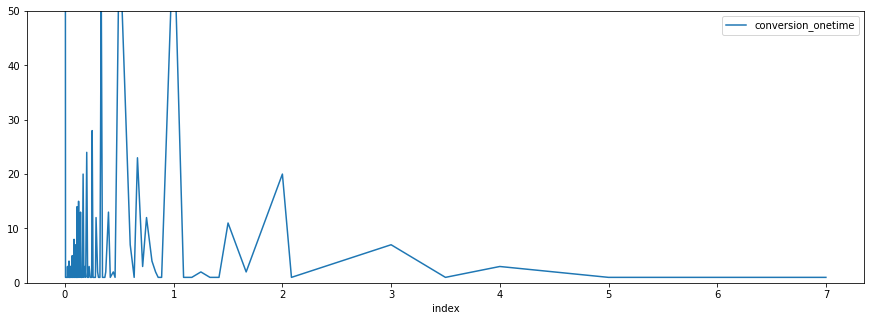

In [30]:
nuoldform['conversion_onetime'].value_counts().reset_index().sort_values('index').plot(x='index', y='conversion_onetime', ylim=(0,50), figsize=(15,5))

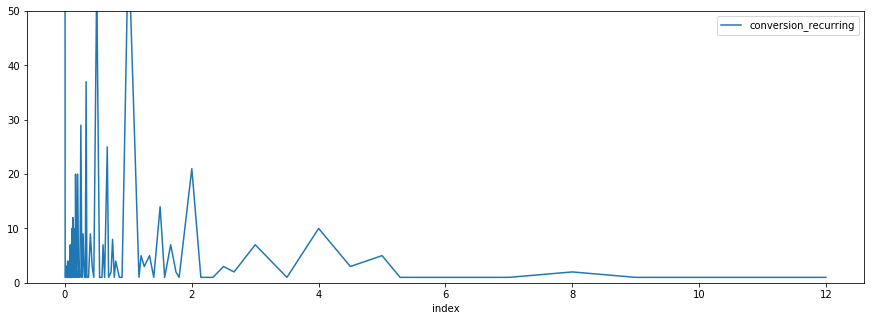

In [31]:
nuoldform['conversion_recurring'].value_counts().reset_index().sort_values('index').plot(x='index', y='conversion_recurring', ylim=(0,50), figsize=(15,5))

In [32]:
daily_conversions['date'].max()

Timestamp('2021-05-31 00:00:00')

In [33]:
print("Last 30 days, all forms, grouped by new/old")
print()

thirty_days_ago = daily_conversions['date'].max() - pd.to_timedelta("30day")
last_30_days = daily_conversions[daily_conversions['date']>=thirty_days_ago]
last_30_days_device = device_conversions[device_conversions['date']>=thirty_days_ago]
last_30_days_rec_frequency = rec_frequencies[rec_frequencies['created']>=thirty_days_ago]

len_conv_forms = len(last_30_days[last_30_days['new template']]['form'].unique())
len_old_forms = len(last_30_days[~last_30_days['new template']]['form'].unique())
len_all_forms = len(last_30_days['form'].unique())

len_conv_trans = last_30_days[last_30_days['new template']]['count_onetime'].sum() + last_30_days[last_30_days['new template']]['count_recurring'].sum()
len_old_trans = last_30_days[~last_30_days['new template']]['count_onetime'].sum() + last_30_days[~last_30_days['new template']]['count_recurring'].sum()
len_all_trans = last_30_days['count_onetime'].sum() + last_30_days['count_recurring'].sum()

print("New form")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_conv_forms, (len_conv_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_conv_trans, (len_conv_trans / len_all_trans) * 100.))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(last_30_days[last_30_days['new template']]['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(last_30_days[last_30_days['new template']]['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(last_30_days[last_30_days['new template']]['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(last_30_days[last_30_days['new template']]['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(last_30_days[last_30_days['new template']]['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(last_30_days[last_30_days['new template']]['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(last_30_days[last_30_days['new template']]['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(last_30_days[last_30_days['new template']]['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(last_30_days[last_30_days['new template']]['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(last_30_days_rec_frequency[last_30_days_rec_frequency['new template']]['frequency'].mean()))
print("\tMedian: {}".format(last_30_days_rec_frequency[last_30_days_rec_frequency['new template']]['frequency'].median()))

print()
print("Settings")
print("Appearance:")
print("\tMean: {}".format(last_30_days[last_30_days['new template']]['appearance'].mean()))
print("\tMedian: {}".format(last_30_days[last_30_days['new template']]['appearance'].median()))
print("Recurring CTA before:")
print("\tMean: {}".format(last_30_days[last_30_days['new template']]['recurring_cta_before'].mean()))
print("\tMedian: {}".format(last_30_days[last_30_days['new template']]['recurring_cta_before'].median()))
print("Recurring CTA after:")
print("\tMean: {}".format(last_30_days[last_30_days['new template']]['recurring_cta_after'].mean()))
print("\tMedian: {}".format(last_30_days[last_30_days['new template']]['recurring_cta_after'].median()))
print("Conditional fields:")
print("\tMean: {}".format(last_30_days[last_30_days['new template']]['conditional_fields'].mean()))
print("\tMedian: {}".format(last_30_days[last_30_days['new template']]['conditional_fields'].median()))

print()

print("Old form")
print("-"*40)
print("Form sample size: {:,} ({:.2f}%)".format(len_old_forms, (len_old_forms / len_all_forms) * 100.))
print("Transaction sample size: {:,} ({:.2f}%)".format(len_old_trans, (len_old_trans / len_all_trans) * 100.))
print("conversion:")
print("\tOne time mean: {:.2f}%".format(last_30_days[~last_30_days['new template']]['conversion_onetime'].mean() * 100.))
print("\tOne time median: {:.2f}%".format(last_30_days[~last_30_days['new template']]['conversion_onetime'].median() * 100.))
print("\tRecurring mean: {:.2f}%".format(last_30_days[~last_30_days['new template']]['conversion_recurring'].mean() * 100.))
print("\tRecurring median: {:.2f}%".format(last_30_days[~last_30_days['new template']]['conversion_recurring'].median() * 100.))
print("per transaction:")
print("\tOne time mean: ${:,.2f}".format(last_30_days[~last_30_days['new template']]['avg_onetime'].mean()))
print("\tOne time median: ${:,.2f}".format(last_30_days[~last_30_days['new template']]['avg_onetime'].median()))
print("\tRecurring mean: ${:,.2f}".format(last_30_days[~last_30_days['new template']]['avg_recurring'].mean()))
print("\tRecurring median: ${:,.2f}".format(last_30_days[~last_30_days['new template']]['avg_recurring'].median()))

print()
print("One time / recurring: {:.2f}".format(last_30_days[~last_30_days['new template']]['onetime / recurring'].mean()))

print()
print("Recurring frequency:")
print("\tMean: {}".format(last_30_days_rec_frequency[~last_30_days_rec_frequency['new template']]['frequency'].mean()))
print("\tMedian: {}".format(last_30_days_rec_frequency[~last_30_days_rec_frequency['new template']]['frequency'].median()))

Last 30 days, all forms, grouped by new/old

New form
----------------------------------------
Form sample size: 274 (6.18%)
Transaction sample size: 2,796.0 (9.94%)
conversion:
	One time mean: 5.87%
	One time median: 0.00%
	Recurring mean: 8.33%
	Recurring median: 0.00%
per transaction:
	One time mean: $336.87
	One time median: $109.48
	Recurring mean: $63.15
	Recurring median: $45.03

One time / recurring: 1.47

Recurring frequency:
	Mean: NaT
	Median: NaT

Settings
Appearance:
	Mean: 0.0
	Median: 0.0
Recurring CTA before:
	Mean: 0.0
	Median: 0.0
Recurring CTA after:
	Mean: 0.0
	Median: 0.0
Conditional fields:
	Mean: 0.0
	Median: 0.0

Old form
----------------------------------------
Form sample size: 4,207 (94.90%)
Transaction sample size: 25,322.0 (90.06%)
conversion:
	One time mean: 2.37%
	One time median: 0.00%
	Recurring mean: 2.84%
	Recurring median: 0.00%
per transaction:
	One time mean: $265.46
	One time median: $105.00
	Recurring mean: $72.51
	Recurring median: $48.33

One t

# new form settings

- recurring_cta_after
- recurring_cta_before
- appearance
- conditional_fields

In [34]:
nuform_settings = pd.read_csv("forms_conversion.csv")

#nuform_settings = nuform_settings[nuform_settings['pageviews']>0]
nuform_settings['conversion_onetime'] = nuform_settings['count_onetime'] / nuform_settings['pageviews']
nuform_settings['conversion_recurring'] = nuform_settings['count_recurring'] / nuform_settings['pageviews']

In [35]:
print("full data set of forms conversions:")
nuform_settings[['recurring_cta_after', 'recurring_cta_before', 'appearance', 'conditional_fields']].mean()

full data set of forms conversions:


recurring_cta_after     0.000066
recurring_cta_before    0.000445
appearance              0.004564
conditional_fields      0.000048
dtype: float64

In [36]:
print("new template form IDs:")
nuform_settings = nuform_settings[nuform_settings['form'].isin(daily_conversions[daily_conversions['new template']]['form'].unique().tolist())]
nuform_settings[['recurring_cta_after', 'recurring_cta_before', 'appearance', 'conditional_fields']].mean()

new template form IDs:


recurring_cta_after     0.000135
recurring_cta_before    0.002749
appearance              0.008473
conditional_fields      0.000043
dtype: float64

In [37]:
settings_cols = ['recurring_cta_after', 'recurring_cta_before', 'appearance', 'conditional_fields']
nuform_settings = nuform_settings.groupby('form')[settings_cols].mean().reset_index()
nuform = daily_conversions.drop(settings_cols, axis=1).merge(nuform_settings, on='form')

In [38]:
nuform[nuform['new template']][settings_cols].mean()

recurring_cta_after     0.000169
recurring_cta_before    0.005404
appearance              0.015553
conditional_fields      0.000076
dtype: float64

## CTA after

In [39]:
print("values sample size: {}".format(len(nuform.groupby('recurring_cta_after')['conversion_onetime'].mean())))
print(nuform.groupby('recurring_cta_after')['conversion_onetime'].mean())
print(nuform.groupby('recurring_cta_after')['conversion_recurring'].mean())

values sample size: 7
recurring_cta_after
0.000000    0.020207
0.002174    0.031896
0.002874    0.043473
0.003781    0.172130
0.004410    0.102041
0.004439    0.011997
0.005800    0.026075
Name: conversion_onetime, dtype: float64
recurring_cta_after
0.000000    0.029050
0.002174    0.038157
0.002874    0.050447
0.003781    0.227569
0.004410    0.098743
0.004439    0.007952
0.005800    0.030987
Name: conversion_recurring, dtype: float64


In [40]:
print("CTA after one time conversion correlation:")
print(nuform.groupby('recurring_cta_after')['conversion_onetime'].mean().reset_index().corr())
print()
print("CTA after recurring conversion correlation:")
print(nuform.groupby('recurring_cta_after')['conversion_recurring'].mean().reset_index().corr())

CTA after one time conversion correlation:
                     recurring_cta_after  conversion_onetime
recurring_cta_after             1.000000            0.199615
conversion_onetime              0.199615            1.000000

CTA after recurring conversion correlation:
                      recurring_cta_after  conversion_recurring
recurring_cta_after              1.000000              0.139726
conversion_recurring             0.139726              1.000000


## CTA before

In [41]:
print("values sample size: {}".format(len(nuform.groupby('recurring_cta_before')['conversion_onetime'].mean())))
print(nuform.groupby('recurring_cta_before')['conversion_onetime'].mean())
print(nuform.groupby('recurring_cta_before')['conversion_recurring'].mean())

values sample size: 129
recurring_cta_before
0.000000    0.018459
0.001153    0.000000
0.001340    0.014325
0.001464    0.020667
0.001552    0.006119
              ...   
0.058824    0.000000
0.061728    0.000000
0.087719    0.000000
0.090909    0.000000
0.100000    0.001689
Name: conversion_onetime, Length: 129, dtype: float64
recurring_cta_before
0.000000    0.027865
0.001153    0.000000
0.001340    0.007857
0.001464    0.032553
0.001552    0.003524
              ...   
0.058824    0.000000
0.061728    0.000000
0.087719    0.000000
0.090909    0.000000
0.100000    0.000676
Name: conversion_recurring, Length: 129, dtype: float64


In [42]:
print("CTA before one time conversion correlation:")
print(nuform.groupby('recurring_cta_before')['conversion_onetime'].mean().reset_index().corr())
print()
print("CTA before recurring conversion correlation:")
print(nuform.groupby('recurring_cta_before')['conversion_recurring'].mean().reset_index().corr())

CTA before one time conversion correlation:
                      recurring_cta_before  conversion_onetime
recurring_cta_before              1.000000           -0.196698
conversion_onetime               -0.196698            1.000000

CTA before recurring conversion correlation:
                      recurring_cta_before  conversion_recurring
recurring_cta_before              1.000000             -0.155593
conversion_recurring             -0.155593              1.000000


## Appearance

In [43]:
print("values sample size: {}".format(len(nuform.groupby('appearance')['conversion_onetime'].mean())))
print(nuform.groupby('appearance')['conversion_onetime'].mean())
print(nuform.groupby('appearance')['conversion_recurring'].median())

values sample size: 213
appearance
0.000000    0.002483
0.001033    0.008685
0.001190    0.013079
0.001810    0.000080
0.001859    0.001379
              ...   
0.150943    0.000000
0.175439    0.000000
0.191489    0.000000
0.200000    0.001689
0.242424    0.000000
Name: conversion_onetime, Length: 213, dtype: float64
appearance
0.000000    0.0
0.001033    0.0
0.001190    0.0
0.001810    0.0
0.001859    0.0
           ... 
0.150943    0.0
0.175439    0.0
0.191489    0.0
0.200000    0.0
0.242424    0.0
Name: conversion_recurring, Length: 213, dtype: float64


In [44]:
print("Appearance one time conversion correlation:")
print(nuform.groupby('appearance')['conversion_onetime'].mean().reset_index().corr())
print()
print("Appearance recurring conversion correlation:")
print(nuform.groupby('appearance')['conversion_recurring'].mean().reset_index().corr())

Appearance one time conversion correlation:
                    appearance  conversion_onetime
appearance            1.000000           -0.146644
conversion_onetime   -0.146644            1.000000

Appearance recurring conversion correlation:
                      appearance  conversion_recurring
appearance              1.000000             -0.128143
conversion_recurring   -0.128143              1.000000


## conditional fields

In [45]:
print(nuform.groupby('conditional_fields')['conversion_onetime'].mean())
print(nuform.groupby('conditional_fields')['conversion_recurring'].mean())

conditional_fields
0.000000    0.021836
0.004375    0.033820
0.006803    0.000000
Name: conversion_onetime, dtype: float64
conditional_fields
0.000000    0.030972
0.004375    0.028117
0.006803    0.000000
Name: conversion_recurring, dtype: float64


In [46]:
print("Conditional fields one time conversion correlation:")
print(nuform.groupby('conditional_fields')['conversion_onetime'].mean().reset_index().corr())
print()
print("Conditional fields recurring conversion correlation:")
print(nuform.groupby('conditional_fields')['conversion_recurring'].mean().reset_index().corr())

Conditional fields one time conversion correlation:
                    conditional_fields  conversion_onetime
conditional_fields            1.000000           -0.502463
conversion_onetime           -0.502463            1.000000

Conditional fields recurring conversion correlation:
                      conditional_fields  conversion_recurring
conditional_fields               1.00000              -0.82313
conversion_recurring            -0.82313               1.00000


# device categories

In [47]:
len_f = device_conversions['new template'].value_counts()[False]
len_t = device_conversions['new template'].value_counts()[True]
perc_f = device_conversions['new template'].value_counts(normalize=True)[False]
perc_t = device_conversions['new template'].value_counts(normalize=True)[True]

print("Template transactions sample")
print("-"*40)
print("Old: {:,} ({:.2f}%)".format(len_f, perc_f*100.))
print("New: {:,} ({:.2f}%)".format(len_t, perc_t*100.))

Template transactions sample
----------------------------------------
Old: 559,970 (96.79%)
New: 18,559 (3.21%)


In [48]:
conv_cols = ['onetime_desktop_conversion', 'onetime_mobile_conversion',
            'recurring_desktop_conversion', 'recurring_mobile_conversion']

In [49]:
print("{}+ device conversion means".format(device_conversions['date'].min()))
device_conversions.replace(np.inf, np.nan).groupby('new template')[conv_cols].mean().reset_index().transpose()

2020-09-01 00:00:00+ device conversion means


,0,1
new template,False,True
onetime_desktop_conversion,0.073948,0.113118
onetime_mobile_conversion,0.043239,0.059858
recurring_desktop_conversion,0.017992,0.009042
recurring_mobile_conversion,0.003599,0.004944


In [50]:
print("{}+ device conversion medians".format(device_conversions['date'].min()))
device_conversions.replace(np.inf, np.nan).groupby('new template')[conv_cols].median().reset_index().transpose()

2020-09-01 00:00:00+ device conversion medians


,0,1
new template,False,True
onetime_desktop_conversion,0.0,0.0
onetime_mobile_conversion,0.0,0.0
recurring_desktop_conversion,0.0,0.0
recurring_mobile_conversion,0.0,0.0


In [51]:
print("Last 60 days conversion means")
device_conversions.replace(np.inf, np.nan)[device_conversions['date']>=sixty_days_ago].groupby('new template')[conv_cols].mean().reset_index().transpose()

Last 60 days conversion means


,0,1
new template,False,True
onetime_desktop_conversion,0.056368,0.132492
onetime_mobile_conversion,0.036451,0.063214
recurring_desktop_conversion,0.004292,0.010609
recurring_mobile_conversion,0.001837,0.005475
